**УСТАНОВКА БИБЛИОТЕК И МОНТИРОВАНИЕ ОБРАЗА ВИРТУАЛЬНОГО ДИСКА**

In [148]:
from google.colab import drive
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statistics as stat
import statsmodels.api as sm
from sklearn.linear_model import PoissonRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [149]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


**СЧИТЫВАНИЕ ФАЙЛА И ЕГО ПРЕДОБРАБОТКА В ФОРМАТ DATAFRAME**

In [150]:
%cd /content/drive/My Drive/stat

/content/drive/My Drive/stat


In [151]:
day = list(range(1,1001))
#series.insert(0, 'day', day)

In [152]:
series = pd.read_csv('task1.txt', sep='\t', header=None, names=['value'])
series

,value
0,1
1,2
2,4
3,2
4,2
...,...
995,2
996,3
997,2
998,1


In [153]:
date = pd.date_range(start='12/1/2020', periods=1000)
date

DatetimeIndex(['2020-12-01', '2020-12-02', '2020-12-03', '2020-12-04',
               '2020-12-05', '2020-12-06', '2020-12-07', '2020-12-08',
               '2020-12-09', '2020-12-10',
               ...
               '2023-08-18', '2023-08-19', '2023-08-20', '2023-08-21',
               '2023-08-22', '2023-08-23', '2023-08-24', '2023-08-25',
               '2023-08-26', '2023-08-27'],
              dtype='datetime64[ns]', length=1000, freq='D')

In [154]:
series.insert(0, 'date', date)
series = series.rename(columns={'value': 'values'})
series

,date,values
0,2020-12-01,1
1,2020-12-02,2
2,2020-12-03,4
3,2020-12-04,2
4,2020-12-05,2
...,...,...
995,2023-08-23,2
996,2023-08-24,3
997,2023-08-25,2
998,2023-08-26,1


**ПОСТРОЕНИЕ ГРАФИКА ВРЕМЕННОГО РЯДА**

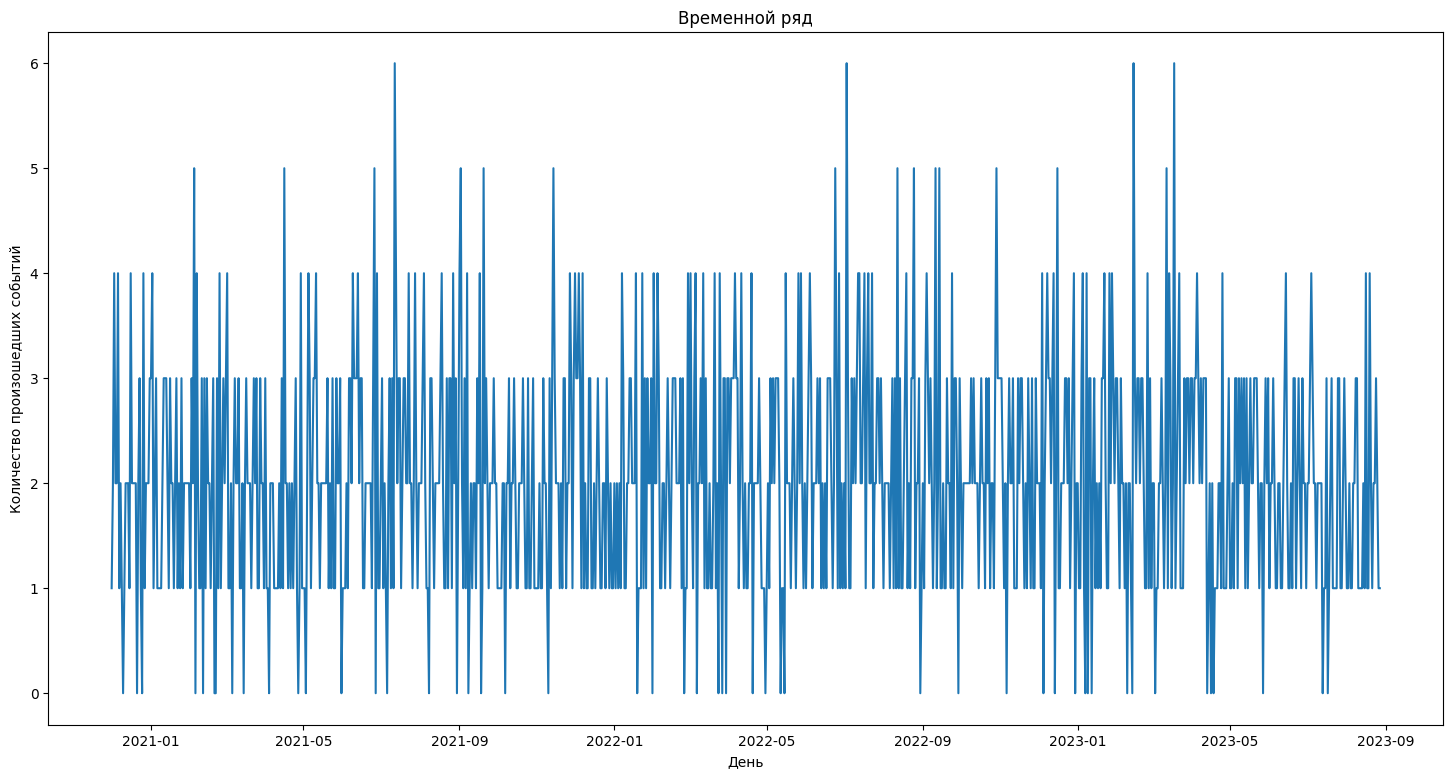

In [155]:
plt.figure(figsize=(18, 9))
x = day
y = series
plt.plot(series['date'], series['values'])
plt.xlabel('День')
plt.ylabel('Количество произошедших событий')
plt.title('Временной ряд')
plt.show()

In [156]:
time_series = series
time_series = time_series.set_index('date')

time_series

,values
date,
2020-12-01,1
2020-12-02,2
2020-12-03,4
2020-12-04,2
2020-12-05,2
...,...
2023-08-23,2
2023-08-24,3
2023-08-25,2


**ПРОВЕРКА НА СЕЗОННОСТЬ (НЕДЕЛЯ, МЕСЯЦ, ГОД)**

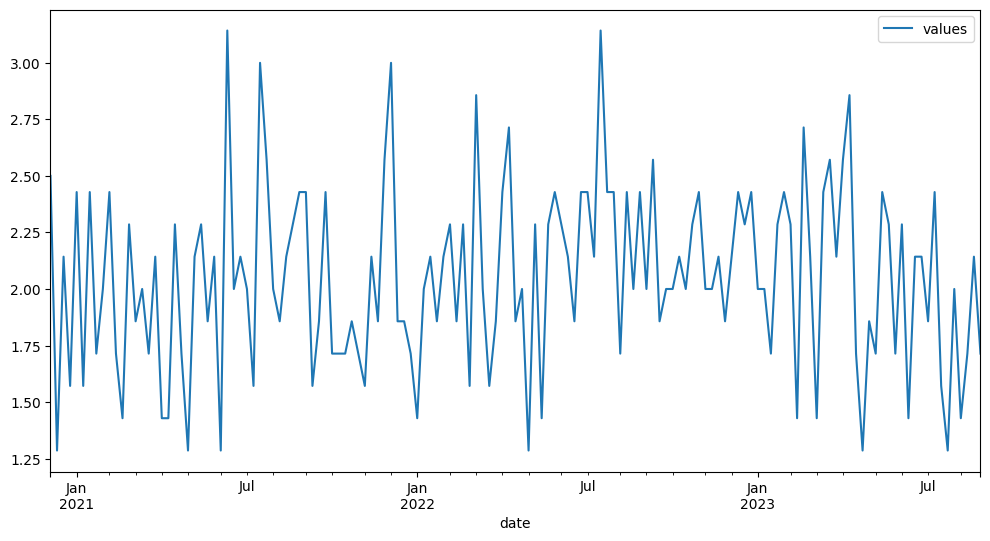

In [157]:
week_series = time_series.resample(rule='W').mean()
week_series.plot(figsize=(12,6))
plt.show()

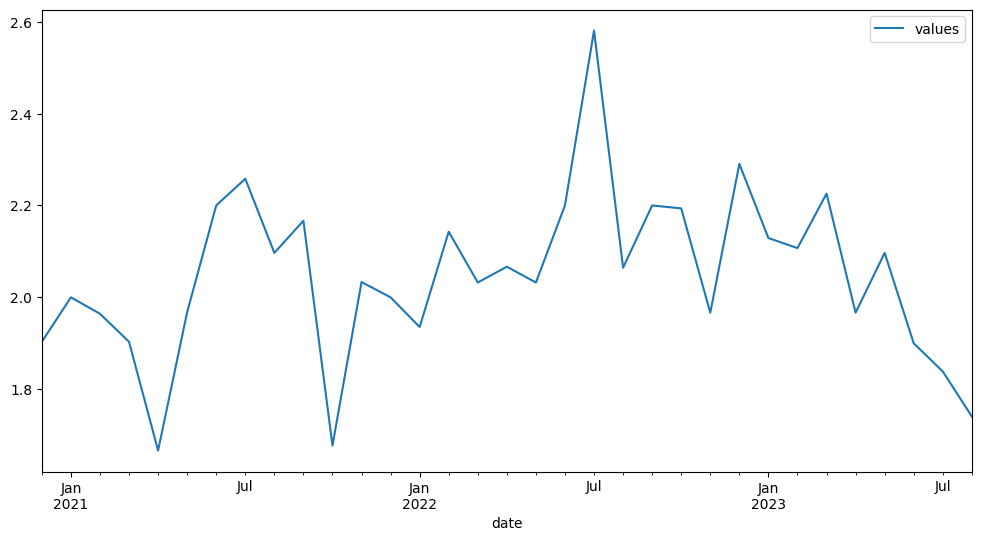

In [158]:
month_series = time_series.resample(rule='M').mean()
month_series.plot(figsize=(12,6))
plt.show()

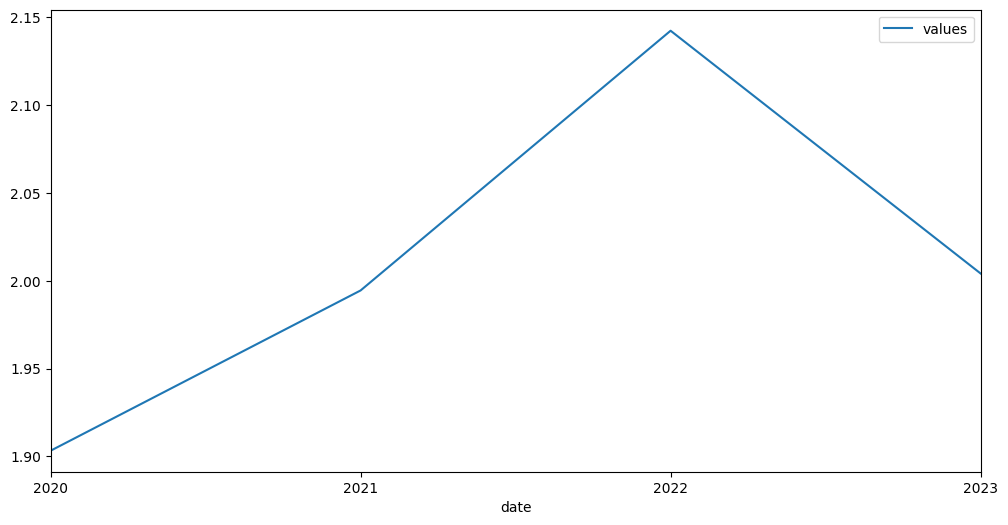

In [159]:
year_series = time_series.resample(rule='Y').mean()
year_series.plot(figsize=(12,6))
plt.show()

**БАЗОВЫЕ СТАТИСТИКИ ВРЕМЕННОГО РЯДА И ГИСТОГРАММА ЧАСТОТЫ ЗНАЧЕНИЙ РЯДА**

,values
count,1000.000000
mean,2.048000
std,1.091278
min,0.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,6.000000


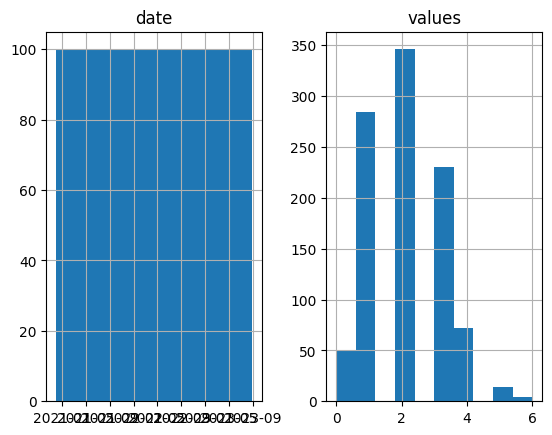

In [160]:
desc = series.describe()
series.hist()
desc

In [161]:
print('Медиана = %f' % (stat.median(series['values'])))
print('Коэф. вариации = %f' % (desc.loc['std']/desc.loc['mean']))
print('Размах = %f' % (desc.loc['max']-desc.loc['min']))

Медиана = 2.000000
Коэф. вариации = 0.532850
Размах = 6.000000


**ПРОВЕРКА РЯДА НА СТАЦИОНАРНОСТЬ**

In [162]:
test = sm.tsa.stattools.adfuller(time_series)

print('Критерий ADF:',test[0])
print('P-value:', test[1])
print('Критические значения:', test[4])

if test[0] < test[4]["5%"]:
  print ("Нулевая гипотеза отвергнута – Временной ряд стационарен")
else:
  print ("Нулевая гипотеза не отвергнута – Временной ряд не стационарен")

Критерий ADF: -12.140334418356398
P-value: 1.6566419665772978e-22
Критические значения: {'1%': -3.43694584277544, '5%': -2.8644520725172873, '10%': -2.5683205291305176}
Нулевая гипотеза отвергнута – Временной ряд стационарен


**ПРОВЕРКА РЯДА НА ОДНОРОДНОСТЬ (СООТВЕТСТВИЕ НОРМАЛЬНОМУ РАСПРЕДЕЛЕНИЮ)**

In [163]:
import scipy
jb_test = scipy.stats.jarque_bera(time_series)
print(jb_test)
print('Ряд не соответствует нормальному распределению, есть ассиметрия и эксцесс')

SignificanceResult(statistic=35.114934884763585, pvalue=2.3707664549323238e-08)
Ряд не соответствует нормальному распределению, есть ассиметрия и эксцесс


**СГЛАЖИВАНИЕ РЯДА МЕТОДОМ СКОЛЬЗЯЩЕЙ СРЕДНЕЙ**

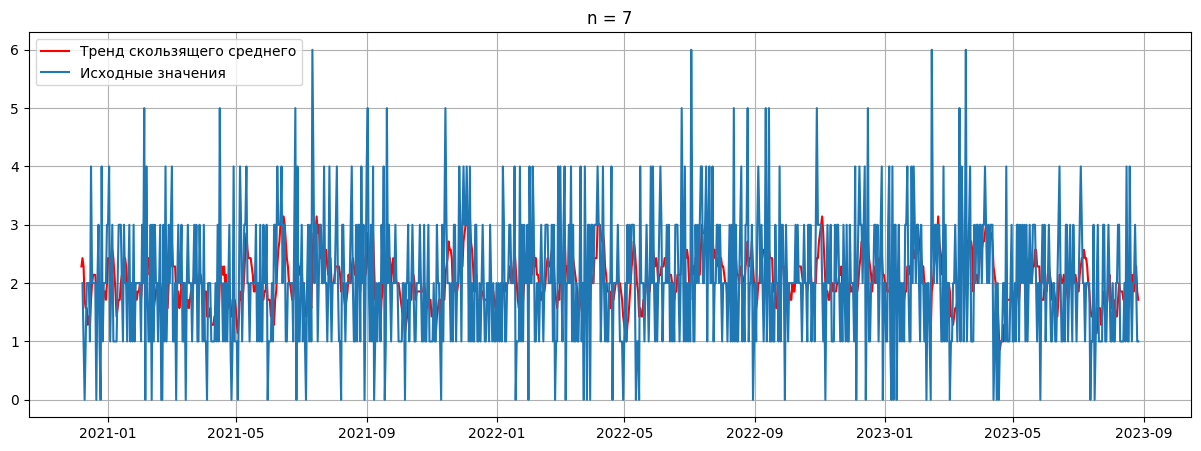

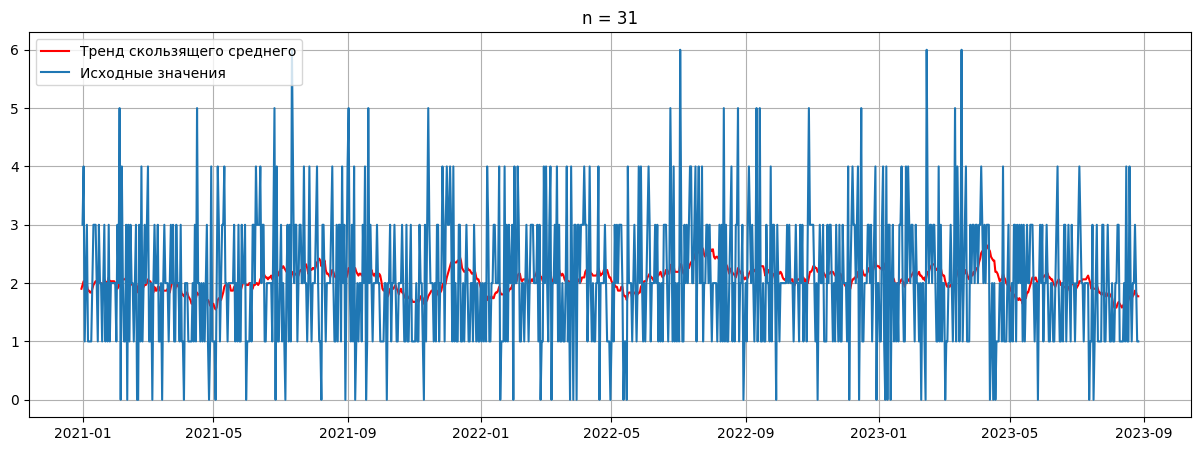

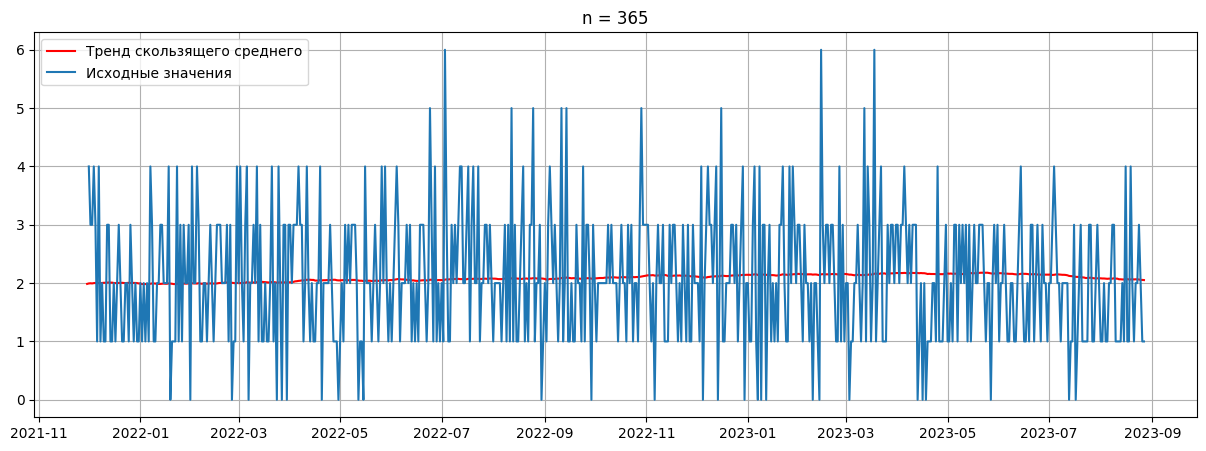

In [164]:
def plotMovingAverage(series, n):
    rolling_mean = series.rolling(window=n).mean()

    plt.figure(figsize=(15,5))
    plt.title("n = {}".format(n))
    plt.plot(rolling_mean, "r", label="Тренд скользящего среднего")

    plt.plot(series[n:], label="Исходные значения")
    plt.legend(loc="upper left")
    plt.grid(True)

plotMovingAverage(time_series, 7) # сглаживание по неделе
plotMovingAverage(time_series, 31) # сглаживание по месяцу
plotMovingAverage(time_series, 365) # сглаживание по году

**Модель регрессии Пуассона**

In [165]:
x = np.array(day)
y = series['values'].values

data = pd.DataFrame({'x': x, 'y': y})

# Добавление столбца с константой (для учета свободного члена)
data = sm.add_constant(data)

data

,const,x,y
0,1.0,1,1
1,1.0,2,2
2,1.0,3,4
3,1.0,4,2
4,1.0,5,2
...,...,...,...
995,1.0,996,2
996,1.0,997,3
997,1.0,998,2
998,1.0,999,1


In [166]:
train, test = train_test_split(data, train_size=0.8, random_state=1)

In [167]:
train_x = train.drop(columns='y', axis=1)
train_y = train['y']

test_x = test.drop(columns='y',axis=1)
test_y = test['y']

**ОБУЧЕНИЕ МОДЕЛИ РЕГРЕССИИ ПУАССОНА**

In [168]:
poisson_model = sm.GLM(train_y, train_x, family=sm.families.Poisson())
poisson_results = poisson_model.fit()

print(poisson_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  800
Model:                            GLM   Df Residuals:                      798
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1249.1
Date:                Mon, 24 Jul 2023   Deviance:                       519.27
Time:                        12:15:27   Pearson chi2:                     460.
No. Iterations:                     4   Pseudo R-squ. (CS):           0.001006
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6940      0.050     14.014      0.0

In [169]:
y_pred = poisson_model.predict(params=[0.6940, 7.607e-05], exog=test_x)
mean_absolute_error(test_y, y_pred)

0.8208577656598763

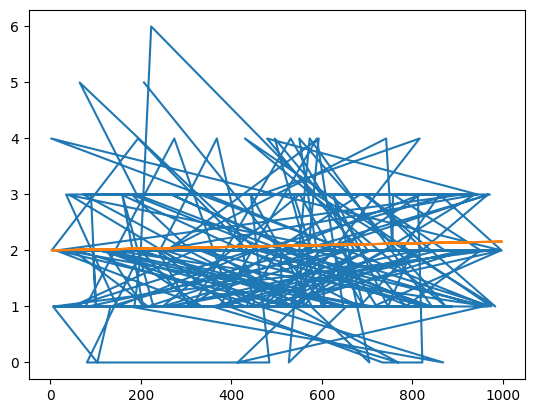

In [170]:
plt.plot(test_y)
plt.plot(test_x['x'].values, y_pred)
plt.show()

**Мною была замечена косинусоидальная зависимость графика**

In [177]:
y_predd = np.cos(x*1500)+2

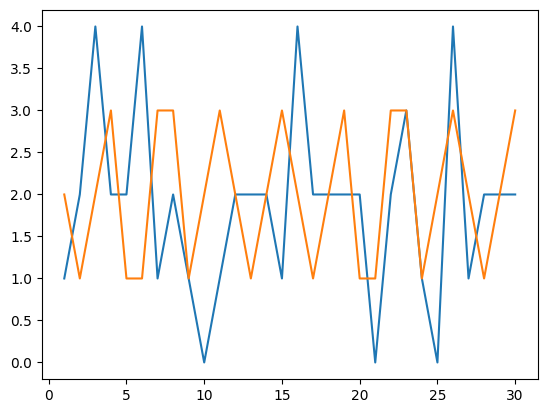

In [175]:
plt.plot(x[:30], y[:30])
plt.plot(x[:30], np.rint(y_predd))
plt.show()

In [178]:
mean_absolute_error(y, y_predd)

1.054536592171659

In [179]:
mean_absolute_error(y, y_pred=[2.048]*1000)

0.83328

**Была построена модель регрессии Пуассона, график косинуса и предсказание по константе (среднему значению). Из значений MAE было выведено решение, что регрессия Пуассона справилась лучше (ее ошибка даже меньше, чем у y_pred от среднего значения). Прогноз будет строиться по графику косинуса и по регрессии Пуассона.**

**ПРОГНОЗ**

**ПРОГНОЗ ЧЕРЕЗ ФУНКЦИЮ COS**

**Данные для прогноза**

In [180]:
x = np.array(day)
y = series['values'].values

In [181]:
x_forecast_1 = np.append(x, 1001)
x_forecast_2 = np.append(x, [1002, 1003])
x_forecast_3 = np.append(x, [1004, 1005, 1006, 1007, 1008, 1009, 1010])

x_forecast_3

array([   1,    2,    3, ..., 1008, 1009, 1010])

In [182]:
y_pred1 = np.cos(x_forecast_3*1500)+2

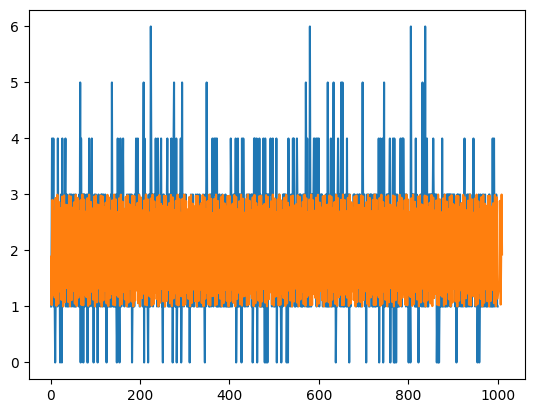

In [183]:
plt.plot(x, y)
plt.plot(x_forecast_3, y_pred1)
plt.show()

**Округлим полученные значения и построим еще один график (ведь изначально у нас был дискретный набор данных)**

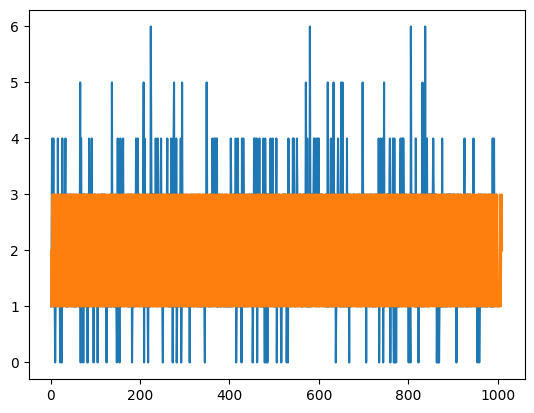

In [184]:
plt.plot(x, y)
plt.plot(x_forecast_3, np.rint(y_pred1))
plt.show()

**Ошибка для неокругленных значений составляет 0.86, для округленных - 1.05**

**ПРОГНОЗ ЧЕРЕЗ РЕГРЕССИЮ ПУАССОНА**

In [185]:
x = np.array(day)
y = series['values'].values

data = pd.DataFrame({'x': x, 'y': y})
df = pd.DataFrame({'x': [1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010],
 'y': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]})
data = data.append(df, ignore_index=True)
data = sm.add_constant(data)
data = data.drop(columns='y', axis=1)
data

,const,x
0,1.0,1
1,1.0,2
2,1.0,3
3,1.0,4
4,1.0,5
...,...,...
1005,1.0,1006
1006,1.0,1007
1007,1.0,1008
1008,1.0,1009


In [186]:
y_pred = poisson_model.predict(params=[0.6940, 7.607e-05], exog=data)

In [187]:
x = np.array(day)
y = series['values'].values

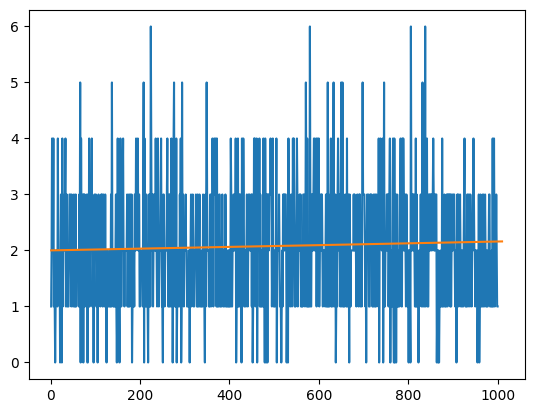

In [188]:
plt.plot(x, y)
plt.plot(data['x'], y_pred)
plt.show()

**Наилучший результат относительно ошибки у модели регрессии Пуассона, но визуально функция косинуса восстановила график лучше. Ошибка у модели регрессии - 0.83, ошибка у косинуса - 0.86. Считаю, что косинус отработал лучше, несмотря на бОльшую ошибку.**